# Support Vector Regressor 
## Demand Prediction 

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
from scipy import stats
warnings.filterwarnings("ignore")

In [12]:
# read in transformed trip data 
bonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)

# drop columns that were created in Data Preparation / new hexagon resolutions will be created below 
bonn_trips.drop(["h3_hex_id"],axis=1, inplace =True) 

bonn_trips.head()

,Code_18,index_right,index_start,p_place_type_start,datetime_start,b_number_start,trip_start,p_uid_start,p_bikes_x,latitude_start,...,precipitation y/n,average_wind_speed (m/s),urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
0,111,568120,1408955,12,2019-07-23 03:40:00,44588,start,19432650,1,50.739942,...,0,0.8,1,0,1,0,0,0,0,0
1,111,351787,900169,12,2019-06-04 06:24:00,44948,start,16723815,1,50.740004,...,0,1.4,1,0,1,0,0,0,0,0
2,111,385172,987042,12,2019-06-12 20:27:00,45365,start,17234429,1,50.740062,...,0,2.8,1,0,1,0,0,0,0,0
3,111,399411,1013340,12,2019-06-15 21:56:00,44826,start,17420319,1,50.740147,...,0,1.3,1,0,1,0,0,0,0,0
4,111,674374,1656407,12,2019-08-23 17:02:00,45201,start,20884736,1,50.740156,...,0,1.4,1,0,1,0,0,0,0,0


# SVR with ... 
* Hexagon resolution = 7 
* time baskets: 
    * 5.00 to 10.59 : Morning
    * 11.00 to 12.59 : noon
    * 13.00 to 17.59 : afternoon
    * 18.00 to 22.59 : evening
    * 23.00 to 4.59 : night

### Data preparation for SVR 

In [13]:
# set new hex resolution for the prediction 
# therefore the start coordinates of one trip is used 
H3_HEXAGON_RESOLUTION = 7
bonn_trips["h3_hex_id"] = bonn_trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], H3_HEXAGON_RESOLUTION) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)

In [14]:
# calculate the centers of the hexagons to use this information for further Support Verctor Regressions 
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

bonn_trips["center"] = bonn_trips["h3_hex_id"].apply(lambda x: centroid(x))
bonn_trips["center_x"] = bonn_trips["center"].apply(lambda x: x[0])
bonn_trips["center_y"]  = bonn_trips["center"].apply(lambda x: x[1])

In [15]:
# returns a time basket 
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0        
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1        
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2        
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3        
    #from 23.00 to 4.59 : night
    if (hour>22 and hour<25)or hour<5:
        x=4
    return x


In [16]:
bonn_trips['time_basket'] = bonn_trips['hour'].apply(lambda x: get_timebasket(x))

In [17]:
bonn_trips.head(5)

,Code_18,index_right,index_start,p_place_type_start,datetime_start,b_number_start,trip_start,p_uid_start,p_bikes_x,latitude_start,...,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,h3_hex_id,center,center_x,center_y,time_basket
0,111,568120,1408955,12,2019-07-23 03:40:00,44588,start,19432650,1,50.739942,...,0,0,0,0,0,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,4
1,111,351787,900169,12,2019-06-04 06:24:00,44948,start,16723815,1,50.740004,...,0,0,0,0,0,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,0
2,111,385172,987042,12,2019-06-12 20:27:00,45365,start,17234429,1,50.740062,...,0,0,0,0,0,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,3
3,111,399411,1013340,12,2019-06-15 21:56:00,44826,start,17420319,1,50.740147,...,0,0,0,0,0,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,3
4,111,674374,1656407,12,2019-08-23 17:02:00,45201,start,20884736,1,50.740156,...,0,0,0,0,0,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,2


In [18]:
# grouped dataframe by following feature - 
# sums up the number of trips for each hex, month, day, timebasket 
grouped_trips = pd.DataFrame(bonn_trips.groupby(['h3_hex_id','month', 'day',"time_basket", "weekend", "weekday","center_x","center_y"], as_index = False).size())
grouped_trips.rename({0:"Demand"},axis=1, inplace=True )
grouped_trips.reset_index(inplace=True)
grouped_trips.head()

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand
0,871fa1010ffffff,12,25,2,False,2,50.623855,7.252811,1
1,871fa1014ffffff,4,27,2,True,5,50.639241,7.233468,1
2,871fa1014ffffff,6,12,2,False,2,50.639241,7.233468,1
3,871fa1016ffffff,10,6,4,True,6,50.620013,7.219637,1
4,871fa1032ffffff,3,3,2,True,6,50.654619,7.214119,3


In [21]:
# grouped dataframe to calculate the mean of the temperatur per day and timebasket 
grouped_weather = pd.DataFrame(bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
grouped_weather.reset_index(inplace=True)
grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)"]]
grouped_weather

,time_basket,h3_hex_id,month,day,temperature °C,precipitaion_level (mm)
0,0,871fa1032ffffff,4,12,3.788889,0.0
1,0,871fa1032ffffff,4,22,19.700000,0.0
2,0,871fa1032ffffff,5,2,9.500000,0.0
3,0,871fa1032ffffff,5,6,6.133333,0.0
4,0,871fa1032ffffff,5,12,9.550000,0.0
...,...,...,...,...,...,...
42062,4,871fa1c6bffffff,5,11,7.100000,0.0
42063,4,871fa1c6bffffff,6,12,14.200000,0.0
42064,4,871fa1c6bffffff,6,13,13.600000,0.0
42065,4,871fa1c6bffffff,6,16,17.500000,0.0


In [20]:
# grouped dataframe to get "precipitation y/n" for the group
grouped_rain_bool = pd.DataFrame(bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
grouped_rain_bool.reset_index(inplace=True)
grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
grouped_rain_bool

,time_basket,h3_hex_id,month,day,precipitation y/n
0,0,871fa1032ffffff,4,12,0
1,0,871fa1032ffffff,4,22,0
2,0,871fa1032ffffff,5,2,0
3,0,871fa1032ffffff,5,6,0
4,0,871fa1032ffffff,5,12,0
...,...,...,...,...,...
42062,4,871fa1c6bffffff,5,11,0
42063,4,871fa1c6bffffff,6,12,1
42064,4,871fa1c6bffffff,6,13,0
42065,4,871fa1c6bffffff,6,16,0


In [26]:
# group by hex, month, day and timebasket 
# use the value for the land features that occurs most often within one group
grouped_land_use = pd.DataFrame(bonn_trips.groupby(['h3_hex_id','month', 'day', 'time_basket'], as_index = False)
                                ['urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric','industry_commercial', 
                                 'green_urban_area', 'agricultural_area', 'forest', 'water_courses'].agg(lambda x:x.value_counts().index[0]))
grouped_land_use.reset_index(inplace=True,drop=True)
grouped_land_use

,index,h3_hex_id,month,day,time_basket,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
0,0,871fa1010ffffff,12,25,2,0,0,0,0,0,0,1,0
1,1,871fa1014ffffff,4,27,2,0,0,0,0,0,0,0,1
2,2,871fa1014ffffff,6,12,2,0,0,0,0,0,0,0,1
3,3,871fa1016ffffff,10,6,4,0,0,0,0,0,0,0,1
4,4,871fa1032ffffff,3,3,2,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42062,42062,871fa1c6bffffff,10,31,2,0,0,0,1,0,0,0,0
42063,42063,871fa1c6bffffff,12,8,1,1,1,0,0,0,0,0,0
42064,42064,871fa1c6dffffff,4,7,2,1,1,0,0,0,0,0,0
42065,42065,871fa1c6dffffff,6,9,0,1,1,0,0,0,0,0,0


In [29]:
# merge mean temperature with the demands 
df_demand = grouped_trips.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get value for precipitation as a boolean value 
df_demand = df_demand.merge(grouped_rain_bool, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# merge to get the correct values for the land features
df_demand = df_demand.merge(grouped_land_use,on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

# final dataframe to predict the demand per hexagon, ... 
df_demand["weekend"] = df_demand["weekend"].apply(lambda x : 1 if x else 0)
df_demand

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm),precipitation y/n,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
0,871fa1010ffffff,12,25,2,0,2,50.623855,7.252811,1,6.4,0.1,1,0,0,0,0,0,0,1,0
1,871fa1014ffffff,4,27,2,1,5,50.639241,7.233468,1,10.5,0.2,1,0,0,0,0,0,0,0,1
2,871fa1014ffffff,6,12,2,0,2,50.639241,7.233468,1,17.8,0.0,0,0,0,0,0,0,0,0,1
3,871fa1016ffffff,10,6,4,1,6,50.620013,7.219637,1,8.3,0.0,1,0,0,0,0,0,0,0,1
4,871fa1032ffffff,3,3,2,1,6,50.654619,7.214119,3,11.2,0.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42062,871fa1c6bffffff,10,31,2,0,3,50.773442,7.025900,1,9.2,0.0,0,0,0,0,1,0,0,0,0
42063,871fa1c6bffffff,12,8,1,1,6,50.773442,7.025900,1,11.1,0.1,1,1,1,0,0,0,0,0,0
42064,871fa1c6dffffff,4,7,2,1,6,50.807942,7.020279,2,19.2,0.0,0,1,1,0,0,0,0,0,0
42065,871fa1c6dffffff,6,9,0,1,6,50.807942,7.020279,1,18.4,0.0,0,1,1,0,0,0,0,0,0


### Explanation of the steps above 
There are created several dataframes where each dataframe is grouped over the hexagon id, the month, the day and the time_basket. 

The reason therefore is that different aggregation functions must be used within the groups for different features. <br>
<b>Demand: </b>size(); sums up the trips within each group <br>
<b>Temperature: </b>mean(); calculates the mean for the temperature within each group <br>
<b>Precipitation y/n:</b> take the true value if it exists within a group <br>
<b>land use features: </b>use the value for the land features that occurs most often within one group<br>

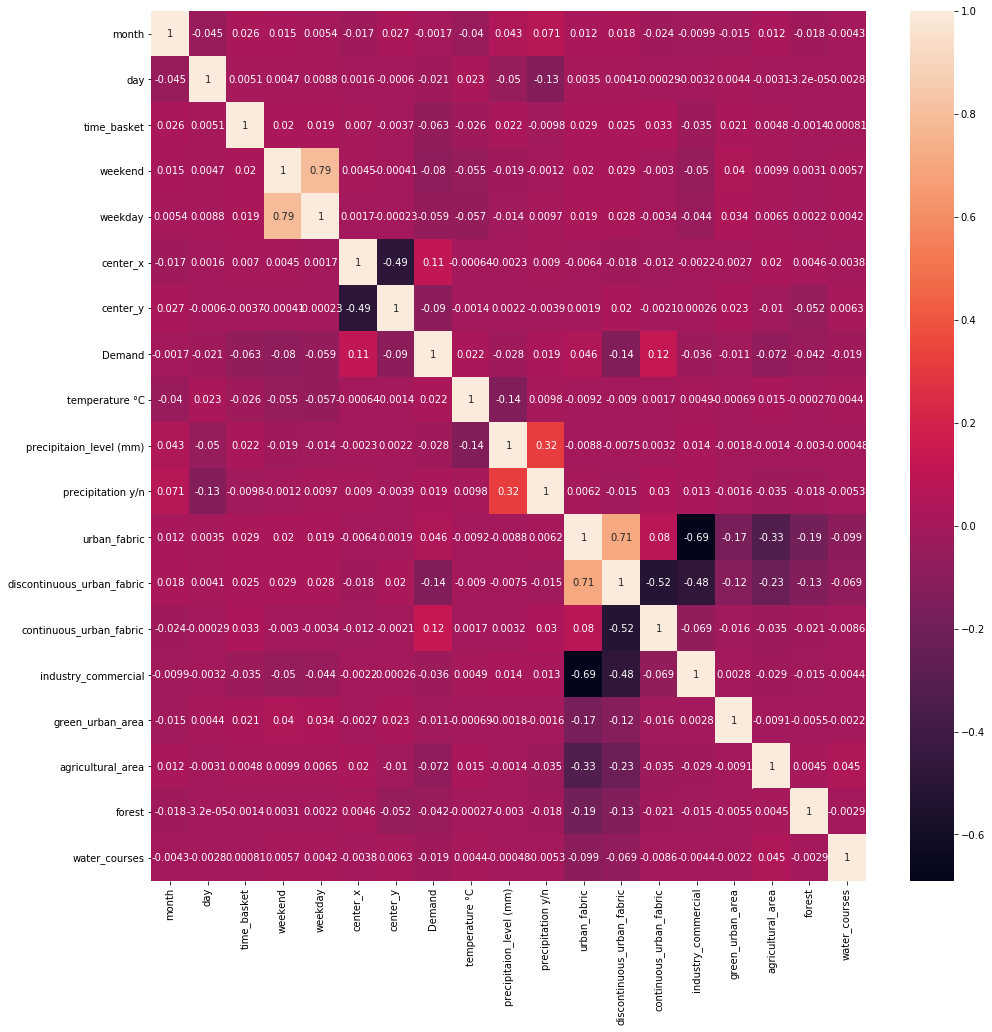

In [34]:
# get a feeling of correlations between the Demand and the other features 
plt.figure(figsize=(16, 16))
sns.heatmap(df_demand.corr(), annot=True)
plt.show()

In [37]:
df_demand.corr()[["Demand"]]

,Demand
month,-0.001675
day,-0.020918
time_basket,-0.063149
weekend,-0.079763
weekday,-0.058590
center_x,0.114642
center_y,-0.089812
Demand,1.000000
temperature °C,0.021656
precipitaion_level (mm),-0.028422


In [39]:
df_demand.describe()
# --> min temperature doesn't make sense 
# this incorrect values are handled below 

,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm),precipitation y/n,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
count,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000
mean,7.025816,15.993439,1.947275,0.285117,2.995531,50.717903,7.119636,24.877552,8.574284,0.072258,0.310647,0.907933,0.831127,0.058977,0.073621,0.004208,0.019184,0.007179,0.001189
std,3.117678,8.846698,1.389721,0.451475,2.002193,0.031972,0.050197,42.743569,66.083148,0.339631,0.462764,0.289125,0.374645,0.235585,0.261156,0.064730,0.137172,0.084425,0.034456
min,1.000000,1.000000,0.000000,0.000000,0.000000,50.585390,7.000860,1.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,8.000000,1.000000,0.000000,1.000000,50.696830,7.078498,3.000000,7.450000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,16.000000,2.000000,0.000000,3.000000,50.719916,7.122848,10.000000,12.800000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,24.000000,3.000000,1.000000,5.000000,50.742822,7.161583,28.000000,17.917708,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,31.000000,4.000000,1.000000,6.000000,50.823229,7.252811,1131.000000,39.400000,14.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# fill incorrect values with mean values of the corresponding month
temp_means = df_demand[df_demand["temperature °C"] >= -25].groupby(["month"]).mean()[["temperature °C"]]
for i, row in df_demand.iterrows():     
    if row["temperature °C"] < -25: # lowest temperature in Germany in 2019 was about -20° Celsius 
        df_demand.at[i, "temperature °C"] = temp_means.iloc[row["month"]]        

In [45]:
df_demand.describe()

,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm),precipitation y/n,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses
count,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000,42067.000000
mean,7.025816,15.993439,1.947275,0.285117,2.995531,50.717903,7.119636,24.877552,13.062569,0.072258,0.310647,0.907933,0.831127,0.058977,0.073621,0.004208,0.019184,0.007179,0.001189
std,3.117678,8.846698,1.389721,0.451475,2.002193,0.031972,0.050197,42.743569,7.360916,0.339631,0.462764,0.289125,0.374645,0.235585,0.261156,0.064730,0.137172,0.084425,0.034456
min,1.000000,1.000000,0.000000,0.000000,0.000000,50.585390,7.000860,1.000000,-24.013208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,8.000000,1.000000,0.000000,1.000000,50.696830,7.078498,3.000000,7.489297,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,16.000000,2.000000,0.000000,3.000000,50.719916,7.122848,10.000000,12.800000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,24.000000,3.000000,1.000000,5.000000,50.742822,7.161583,28.000000,17.917708,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,31.000000,4.000000,1.000000,6.000000,50.823229,7.252811,1131.000000,39.400000,14.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
# create new feature for better prediction results 
# distances from the center of the hexagons to the CentralStation / University 
df_demand["distanceToCentralStation"] = df_demand[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
df_demand["distanceToUniversity"] = df_demand[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)

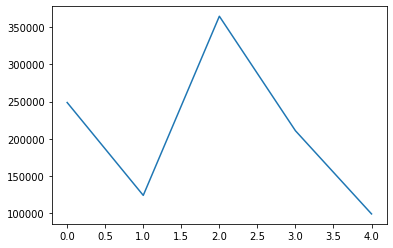

In [47]:
a = df_demand.groupby(["time_basket"]).sum()
a.reset_index(inplace=True)
plt.plot(a["time_basket"], a["Demand"])
# timeBasket = 2: 13-18 - "isAfternoon" might be a good feature 

In [48]:
df_demand["isAfternoon"] = df_demand["time_basket"].apply(lambda x: 1 if x==2 else 0)

In [49]:
df_demand

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,...,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity,isAfternoon
0,871fa1010ffffff,12,25,2,0,2,50.623855,7.252811,1,6.4,...,0,0,0,0,0,1,0,16.308033,16.297206,1
1,871fa1014ffffff,4,27,2,1,5,50.639241,7.233468,1,10.5,...,0,0,0,0,0,0,1,14.122195,14.122802,1
2,871fa1014ffffff,6,12,2,0,2,50.639241,7.233468,1,17.8,...,0,0,0,0,0,0,1,14.122195,14.122802,1
3,871fa1016ffffff,10,6,4,1,6,50.620013,7.219637,1,8.3,...,0,0,0,0,0,0,1,15.174028,15.056790,0
4,871fa1032ffffff,3,3,2,1,6,50.654619,7.214119,3,11.2,...,0,0,0,0,1,0,0,11.939101,11.955306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42062,871fa1c6bffffff,10,31,2,0,3,50.773442,7.025900,1,9.2,...,0,0,1,0,0,0,0,6.815211,6.826739,1
42063,871fa1c6bffffff,12,8,1,1,6,50.773442,7.025900,1,11.1,...,1,0,0,0,0,0,0,6.815211,6.826739,0
42064,871fa1c6dffffff,4,7,2,1,6,50.807942,7.020279,2,19.2,...,1,0,0,0,0,0,0,10.036203,10.237519,1
42065,871fa1c6dffffff,6,9,0,1,6,50.807942,7.020279,1,18.4,...,1,0,0,0,0,0,0,10.036203,10.237519,0


In [52]:
df_demand.columns

Index(['h3_hex_id', 'month', 'day', 'time_basket', 'weekend', 'weekday',
       'center_x', 'center_y', 'Demand', 'temperature °C',
       'precipitaion_level (mm)', 'precipitation y/n', 'urban_fabric',
       'discontinuous_urban_fabric', 'continuous_urban_fabric',
       'industry_commercial', 'green_urban_area', 'agricultural_area',
       'forest', 'water_courses', 'distanceToCentralStation',
       'distanceToUniversity', 'isAfternoon'],
      dtype='object')

## SVRs

In [73]:
def runSVR(featureList,kernel="rbf",C=1,epsilon=0.1, gamma="scale"): 
    X = df_demand[featureList]
    y = df_demand[["Demand"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    
    scaler = StandardScaler()

    svr = SVR(kernel,C=C,epsilon=epsilon,gamma=gamma)
    svr.fit(scaler.fit_transform(X_train), y_train)
    y_pred = svr.predict(scaler.fit_transform(X_train))

    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    print('ON TRAINING DATA', '\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse)
    
    y_pred = svr.predict(scaler.fit_transform(X_test))

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print('ON TEST DATA', '\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse)    

In [74]:
features = ["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
               "distanceToCentralStation","distanceToUniversity","isAfternoon","urban_fabric","industry_commercial", "green_urban_area"]
runSVR(features)

ON TRAINING DATA 
 R2:  0.38978793766819464 
 Mean absolute error:  14.526730221269336 
 Mean squared error:  1084.7986317605655
ON TEST DATA 
 R2:  0.3791197413407471 
 Mean absolute error:  15.212078069287145 
 Mean squared error:  1205.4997103793885


In [75]:
features = ["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
               "distanceToCentralStation","distanceToUniversity","isAfternoon","urban_fabric","industry_commercial", "green_urban_area"]
runSVR(features,C=10,epsilon=10,gamma=0.1)

ON TRAINING DATA 
 R2:  0.5772006913402725 
 Mean absolute error:  12.824237128654735 
 Mean squared error:  751.6274093152741
ON TEST DATA 
 R2:  0.5717054445620693 
 Mean absolute error:  13.542679988876777 
 Mean squared error:  831.5757432075987


Metrics/ results on Training Data are close to the results on the Test Data --> Model is not overfitted

# Grid Search

In [18]:
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.5, 1, 5, 10],
            'gamma': [0.1, 0.5, 1, 5, 10]
        },
        cv=3, scoring="r2", verbose=0, n_jobs=-1)

In [19]:
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_

In [20]:
best_params

{'C': 10, 'epsilon': 10, 'gamma': 0.1}

In [21]:
# after first grid search
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
scaler = StandardScaler()

svr = SVR("rbf",C=10, epsilon=10,gamma=0.1)
svr.fit(scaler.fit_transform(X_train), y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse)


 R2:  0.5501122282421573 
 Mean absolute error:  13.38463951211643 
 Mean squared error:  821.9237726725868


In [15]:
# second try 
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)

In [16]:
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_

In [17]:
best_params

{'C': 15, 'epsilon': 5, 'gamma': 0.05}

In [18]:
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
scaler = StandardScaler()

svr = SVR("rbf",C=15, epsilon=5,gamma=0.05)
svr.fit(scaler.fit_transform(X_train), y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse)


 R2:  0.5074214411443705 
 Mean absolute error:  13.372858681326358 
 Mean squared error:  899.9178302853862


In [19]:
# third try 
gsc = GridSearchCV(
        estimator=SVR("sigmoid"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 1, 'epsilon': 5, 'gamma': 0.01}

In [20]:
svr = SVR("sigmoid",C=1, epsilon=5,gamma=0.01)
svr.fit(scaler.fit_transform(X_train), y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse)


 R2:  0.06823150682324186 
 Mean absolute error:  19.11097037399256 
 Mean squared error:  1702.2971577487467


In [ ]:
gsc = GridSearchCV(
        estimator=SVR("poly"),
        param_grid={   
            #"degree":[3,4],
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params